# AWS Runs 1–10 Summary

This notebook aggregates epoch timings (and accuracies if available) for AWS runs 1–10, using provided console outputs only. It computes per‑run and overall stats, flags outliers, and produces plots.

In [1]:
# Setup
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (12,4)})
ARTIFACTS_DIR = 'artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
print('Artifacts dir:', os.path.abspath(ARTIFACTS_DIR))

Artifacts dir: /Users/venkata/Documents/CAL_POLY_CSC/CSC410/azure-run/artifacts


In [7]:
# Epoch timings (seconds) per run
# Runs 1–5 from prior analysis; runs 6–10 populated from transcribed logs.
aws_epoch_times = {
    'aws_run1':[58,57,57,57,53,53,53,57,53,53],
    'aws_run2':[54,54,82,54,54,57,57,82,57,54],
    'aws_run3':[55,54,57,57,54,57,57,54,53,54],
    'aws_run4':[55,54,54,54,54,53,54,82,57,82],
    'aws_run5':[54,54,53,54,57,57,54,53,53,54],
    'aws_run6':[58,56,56,56,55,59,56,82,56,82],
    'aws_run7':[56,56,56,82,55,59,56,56,56,56],
    'aws_run8':[59,55,56,82,56,56,56,59,56,56],
    'aws_run9':[56,56,55,56,56,59,56,82,55,56],
    'aws_run10':[56,56,82,56,59,59,59,56,56,59],
}
print({k: len(v) for k,v in aws_epoch_times.items()})

{'aws_run1': 10, 'aws_run2': 10, 'aws_run3': 10, 'aws_run4': 10, 'aws_run5': 10, 'aws_run6': 10, 'aws_run7': 10, 'aws_run8': 10, 'aws_run9': 10, 'aws_run10': 10}


In [8]:
# Build timing DataFrame
rows = []
for run, times in aws_epoch_times.items():
    for i,t in enumerate(times, start=1):
        rows.append({'run': run, 'epoch': i, 'seconds': t})
df_times = pd.DataFrame(rows)

if df_times.empty:
    print('No epoch timing data. Please populate aws_epoch_times for runs 6–10.')
else:
    run_stats = df_times.groupby('run')['seconds'].agg(['mean','std','min','max'])
    all_mean = df_times['seconds'].mean()
    all_median = df_times['seconds'].median()
    all_std = df_times['seconds'].std()
    typical_pct = df_times['seconds'].between(df_times['seconds'].quantile(0.10), df_times['seconds'].quantile(0.90)).mean()*100
    print(f'Aggregate mean: {all_mean:.2f}s  median: {all_median:.2f}s  std: {all_std:.2f}s  central(10-90%) coverage: {typical_pct:.1f}%')
    display(run_stats)

Aggregate mean: 58.30s  median: 56.00s  std: 8.11s  central(10-90%) coverage: 80.0%


,mean,std,min,max
run,,,,
aws_run1,55.1,2.233582,53,58
aws_run10,59.8,7.941452,56,82
aws_run2,60.5,11.413929,54,82
aws_run3,55.2,1.619328,53,57
aws_run4,59.9,11.694728,53,82
aws_run5,54.3,1.494434,53,57
aws_run6,61.6,10.813572,55,82
aws_run7,58.8,8.216515,55,82
aws_run8,59.1,8.157478,55,82


/var/folders/2x/9_v8gq357w35fmsfsmdm9dq40000gn/T/ipykernel_68056/4082483077.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(filtered, labels=order, vert=True, showfliers=True)


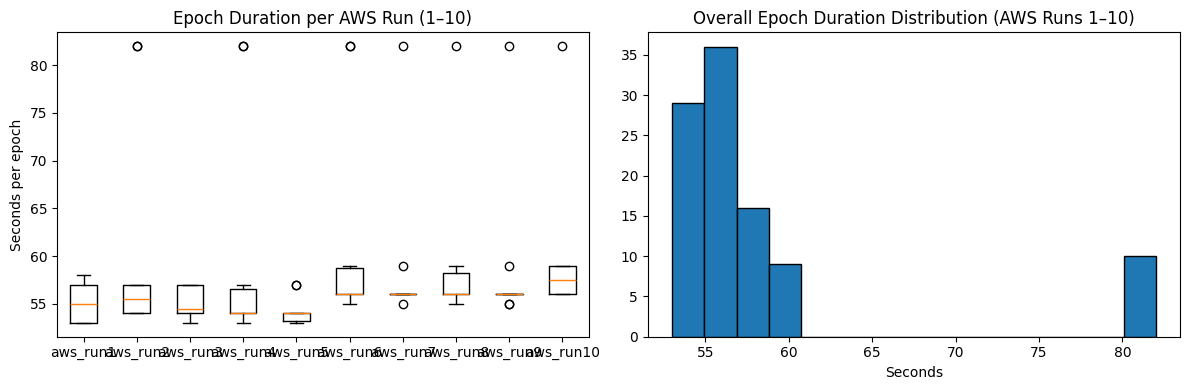

Saved figure: artifacts/aws_epoch_times_1_10.png


In [9]:
# Plots
import matplotlib.pyplot as plt
if df_times.empty:
    print('Skip plotting: no timing data.')
else:
    plt.figure(figsize=(12,4))
    order = sorted(df_times['run'].unique(), key=lambda r: int(re.search(r'(\d+)', r).group(1)))
    filtered = [df_times[df_times['run']==r]['seconds'].values for r in order]
    plt.subplot(1,2,1)
    plt.boxplot(filtered, labels=order, vert=True, showfliers=True)
    plt.ylabel('Seconds per epoch')
    plt.title('Epoch Duration per AWS Run (1–10)')
    plt.subplot(1,2,2)
    plt.hist(df_times['seconds'], bins=min(15, max(5, len(df_times)//2)), edgecolor='black')
    plt.xlabel('Seconds')
    plt.title('Overall Epoch Duration Distribution (AWS Runs 1–10)')
    plt.tight_layout()
    fig_path = os.path.join(ARTIFACTS_DIR, 'aws_epoch_times_1_10.png')
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print('Saved figure:', fig_path)

In [10]:
# Outlier detection (z-score)
if not df_times.empty and df_times['seconds'].std() not in (0, np.nan):
    mu = df_times['seconds'].mean()
    sigma = df_times['seconds'].std(ddof=1)
    df_times['z'] = (df_times['seconds'] - mu) / sigma
    outliers = df_times[df_times['z'].abs() > 3]
    display(outliers)
else:
    print('Not enough variance to compute z-scores or no timing data.')

,run,epoch,seconds,z
